# Lectura y Análisis

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import PchipInterpolator

from sklearn.neighbors import NearestNeighbors

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [24]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file + ".csv"
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        print(df_hourly.iloc[0])
        print(df_hourly.iloc[-1])
        
        dataframes[file] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [25]:
# Read the CSV files
directory = "data/"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

location = "santa_cruz"

grafcan = "grafcan_santa_cruz"
openmeteo_arpege = "openmeteo_santa_cruz_arpege"
openmeteo_icon = "openmeteo_santa_cruz_icon"

data_files = [grafcan, openmeteo_arpege, openmeteo_icon]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing grafcan_santa_cruz...
air_temperature           19.145507
atmospheric_pressure    1012.343994
relative_humidity         71.472382
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.551358
atmospheric_pressure    1008.314667
relative_humidity         69.374166
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_santa_cruz_arpege...
air_temperature           17.2
atmospheric_pressure    1013.3
relative_humidity         88.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.1
atmospheric_pressure    1008.5
relative_humidity         71.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64
Processing openmeteo_santa_cruz_icon...
air_temperature           18.8
atmospheric_pressure    1013.4
relative_humidity         83.0
Name: 2023-03-01 00:00:00+00:00, dtype: float64
air_temperature           17.9
atmospheric_pressure    1008.6
relative_humidity         69.0
Name: 2025-02-28 23:00:00+00:00, dtype: float64


## Visualización

In [26]:
def plot_datasets_comparison(dataframes, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    print ("Plotting " + column)
    
    df_names = dataframes.keys()
    dfs = dataframes.values()
    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=df_names)
    
    # Ensure the indicated column exists in every dataset
    for name in df_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in df_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

### OpenMeteo

Plotting air_temperature


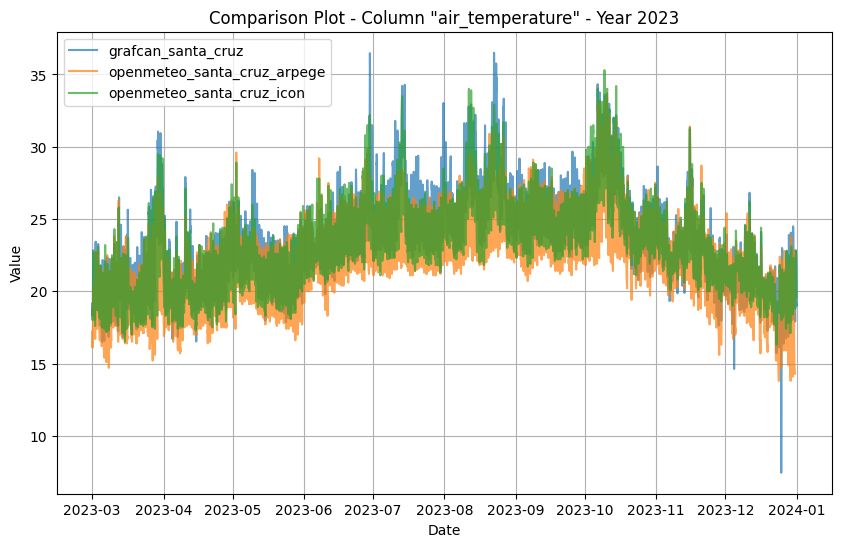

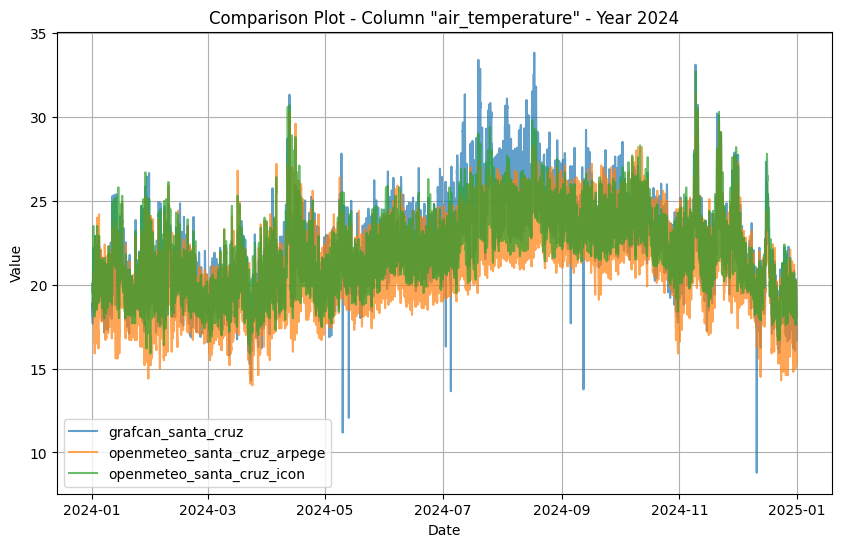

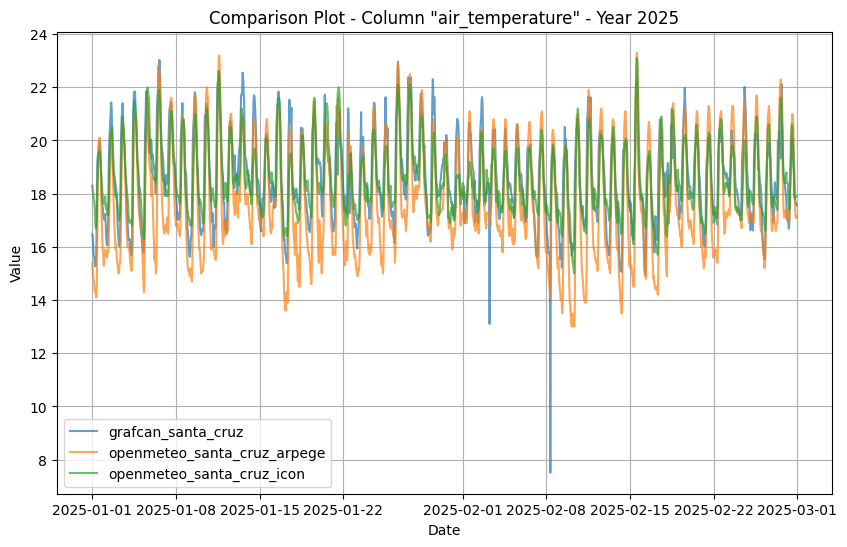

Plotting relative_humidity


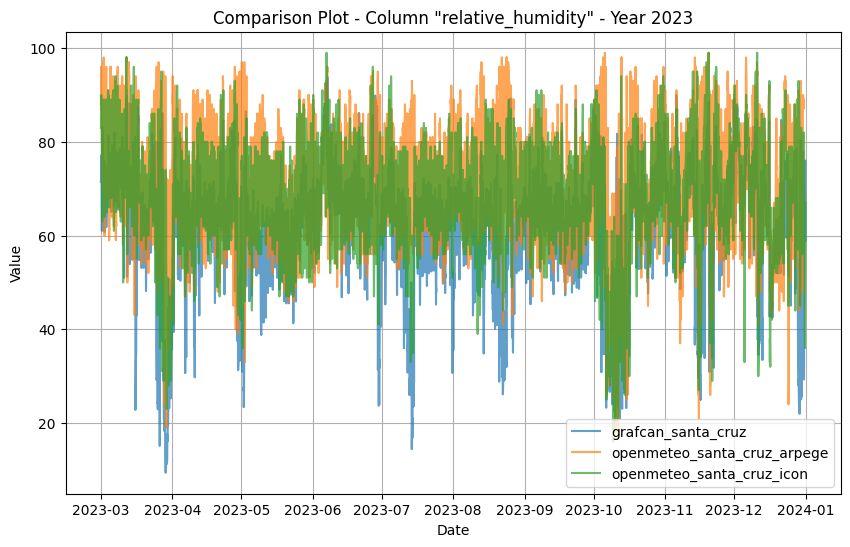

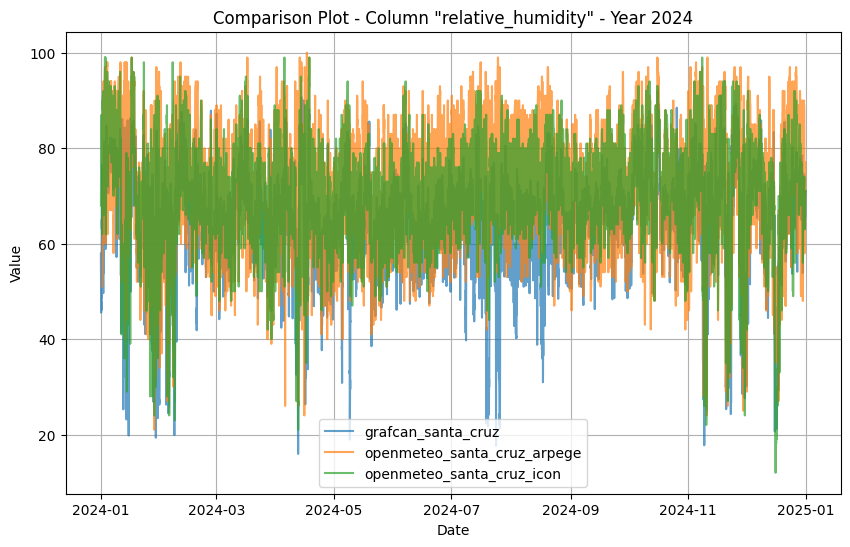

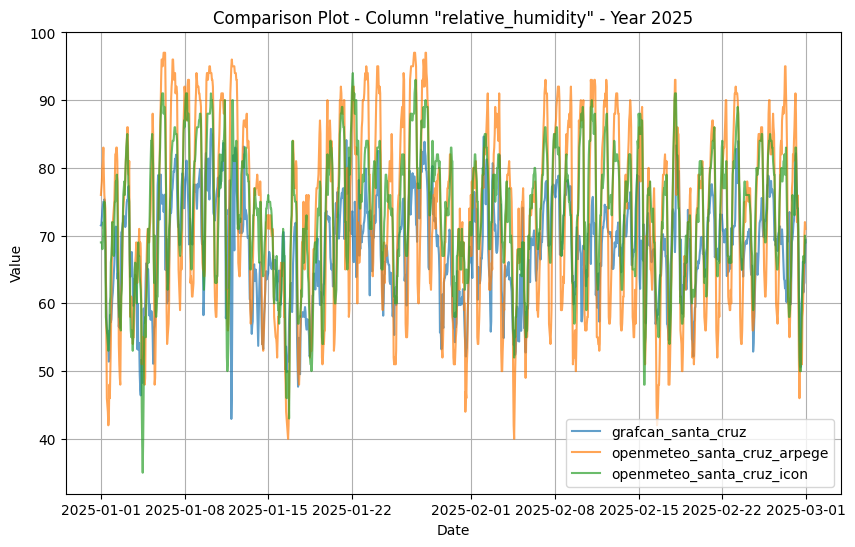

Plotting atmospheric_pressure


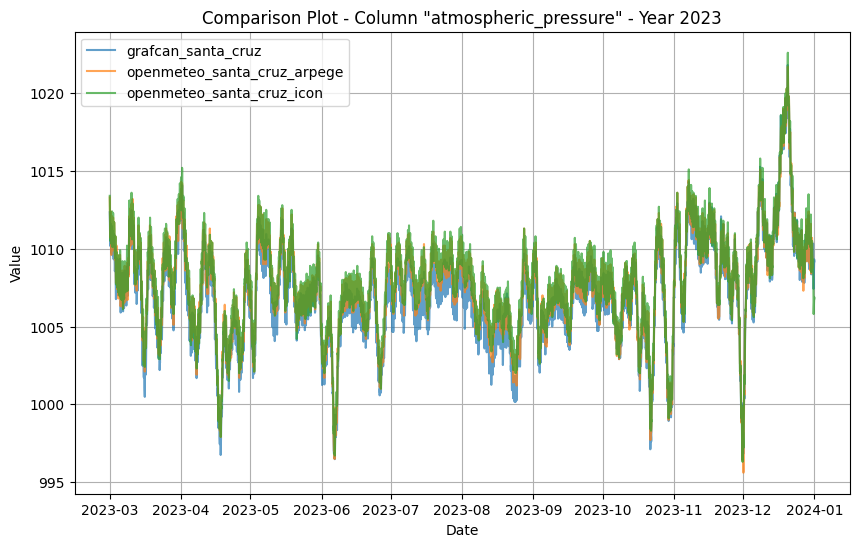

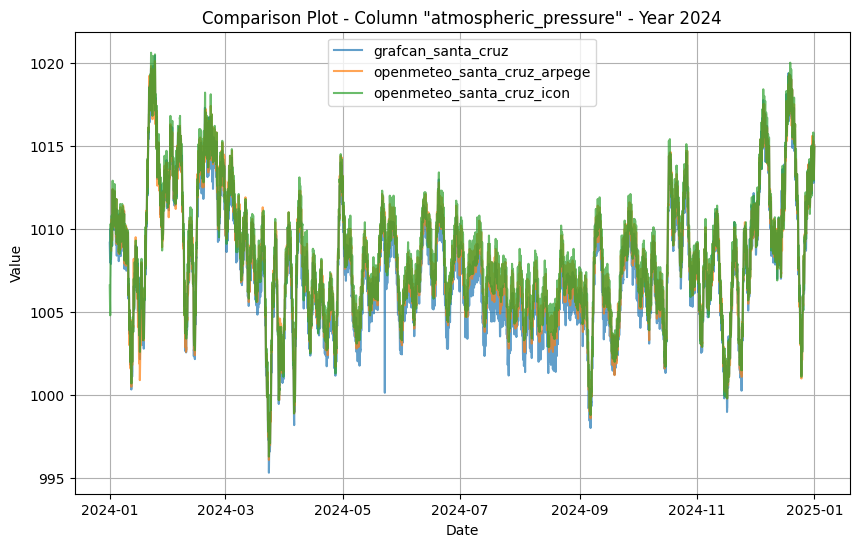

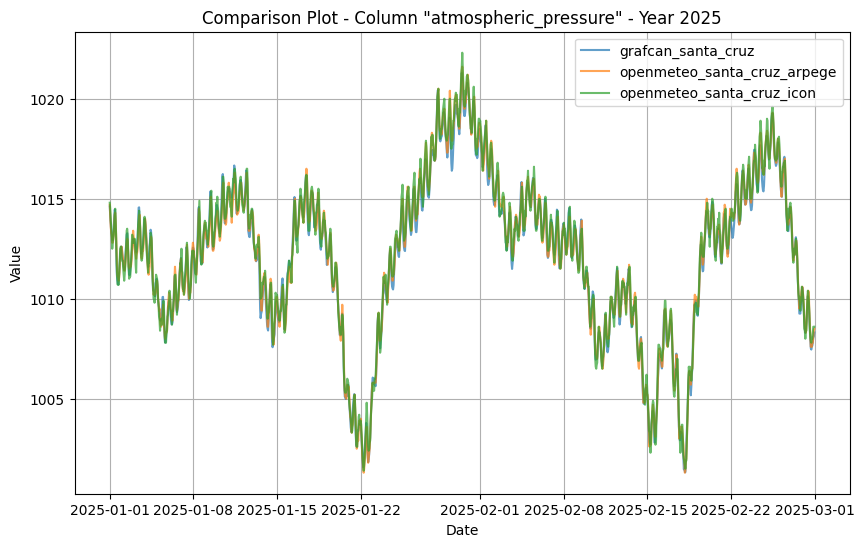

In [27]:
plot_datasets_comparison(dataframes, "air_temperature")
plot_datasets_comparison(dataframes, "relative_humidity")
plot_datasets_comparison(dataframes, "atmospheric_pressure")

## Horas faltantes

In [28]:
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

No missing hours in grafcan_santa_cruz after resampling.
Missing hours in openmeteo_santa_cruz_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'), Timestamp('2023-12-31 22:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC'), Timestamp('2024-01-01 00:00:00+0000', tz='UTC'

### Manejo Horas faltantes

In [29]:
# Use pchip interpolation if gap is small (less or equal to threshold hours) else, use previous day data
def missing_interpolation(df, interpolation_threshold=4):
    # Ensure index is datetime
    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Index must be a DatetimeIndex.")

    # Convert datetime index to numeric for interpolation
    numeric_index = df.index.astype('int64') // 10**9

    # Initialize artificial_value_flag column with zeros if not present
    if "artificial_value_flag" not in df.columns:
        df["artificial_value_flag"] = 0

    for col in df.columns:
        if col == "artificial_value_flag":
            continue

        series = df[col].copy()
        is_nan = series.isna()
        nan_groups = (is_nan != is_nan.shift()).cumsum()
        nan_runs = is_nan.groupby(nan_groups).sum()
        nan_starts = is_nan.groupby(nan_groups).agg(lambda x: x.index[0])

        # Process each missing block
        for run_length, start_time in zip(nan_runs, nan_starts):
            if run_length == 0:
                continue

            end_time = start_time + pd.Timedelta(hours=run_length - 1)
            time_range = pd.date_range(start_time, end_time, freq="h")

            if run_length > interpolation_threshold:
                # Fill using previous day's same hours
                prev_day_range = time_range - pd.Timedelta(days=1)
                try:
                    fill_values = df.loc[prev_day_range, col].values
                    df.loc[time_range, col] = fill_values
                    df.loc[time_range, "artificial_value_flag"] = 1
                except KeyError:
                    print(f"Previous day data not available to fill gap starting {start_time}")
            else:
                # Will interpolate these later
                continue

        # Interpolate remaining missing values (<= threshold hours)
        remaining_nan = df[col].isna()
        valid_mask = ~remaining_nan

        if valid_mask.sum() >= 2:
            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)
            df.loc[remaining_nan, col] = interpolated_values[remaining_nan]
            df.loc[remaining_nan, "artificial_value_flag"] = 1
        else:
            print(f"Not enough data points to interpolate column '{col}'.")

    return df

In [30]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    missing_interpolation(df_hourly)

## Comparativa datasets openmeteo

In [31]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1].drop(columns=["artificial_value_flag"])
    df2 = dataframes[file2].drop(columns=["artificial_value_flag"])
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [32]:
datasets_similarity(openmeteo_icon, grafcan)

Similarity Metrics for openmeteo_santa_cruz_icon vs grafcan_santa_cruz
  air_temperature:
    Pearson: 0.9282
    Spearman: 0.9420
    Kendall: 0.7971
    MSE: 1.5891
    Euclidean Distance: 166.9710
  atmospheric_pressure:
    Pearson: 0.9864
    Spearman: 0.9812
    Kendall: 0.8921
    MSE: 1.1021
    Euclidean Distance: 139.0482
  relative_humidity:
    Pearson: 0.5943
    Spearman: 0.5981
    Kendall: 0.4481
    MSE: 163.1897
    Euclidean Distance: 1692.0400


In [33]:
datasets_similarity(openmeteo_arpege, grafcan)

Similarity Metrics for openmeteo_santa_cruz_arpege vs grafcan_santa_cruz
  air_temperature:
    Pearson: 0.8954
    Spearman: 0.9178
    Kendall: 0.7603
    MSE: 3.8894
    Euclidean Distance: 261.2196
  atmospheric_pressure:
    Pearson: 0.9899
    Spearman: 0.9866
    Kendall: 0.9092
    MSE: 0.6317
    Euclidean Distance: 105.2704
  relative_humidity:
    Pearson: 0.4586
    Spearman: 0.5042
    Kendall: 0.3772
    MSE: 253.5877
    Euclidean Distance: 2109.2516


### Selección de datasets

In [34]:
ned_df_openmeteo = "openmeteo_" + location
dataframes[ned_df_openmeteo] = dataframes[openmeteo_icon].copy()
dataframes[ned_df_openmeteo]["atmospheric_pressure"] = dataframes[openmeteo_arpege]["atmospheric_pressure"].copy()
dataframes[ned_df_openmeteo]["artificial_value_flag"] += dataframes[openmeteo_arpege]["artificial_value_flag"]

# Erase individual dataframes
del dataframes[openmeteo_icon]
del dataframes[openmeteo_arpege]

## Detección de outliers



### Análisis IQR

In [35]:
def detect_outliers_iqr(df, columns, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df[columns].columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing grafcan_santa_cruz:


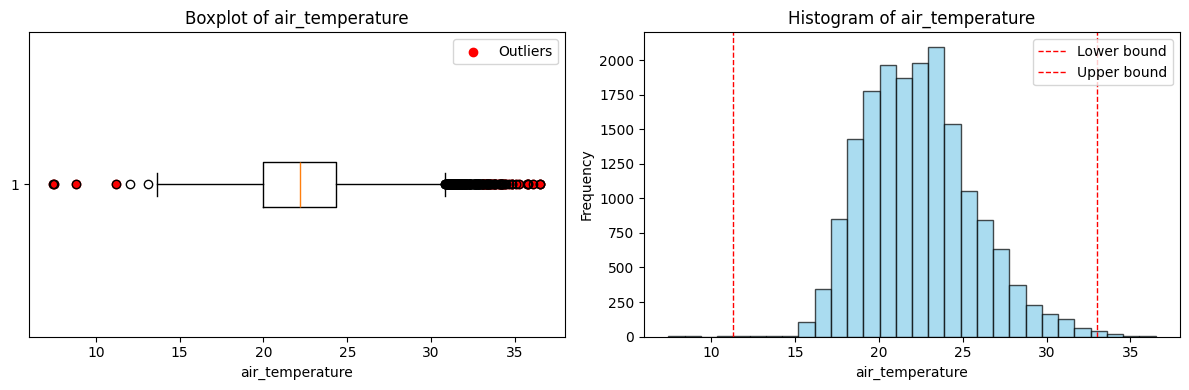

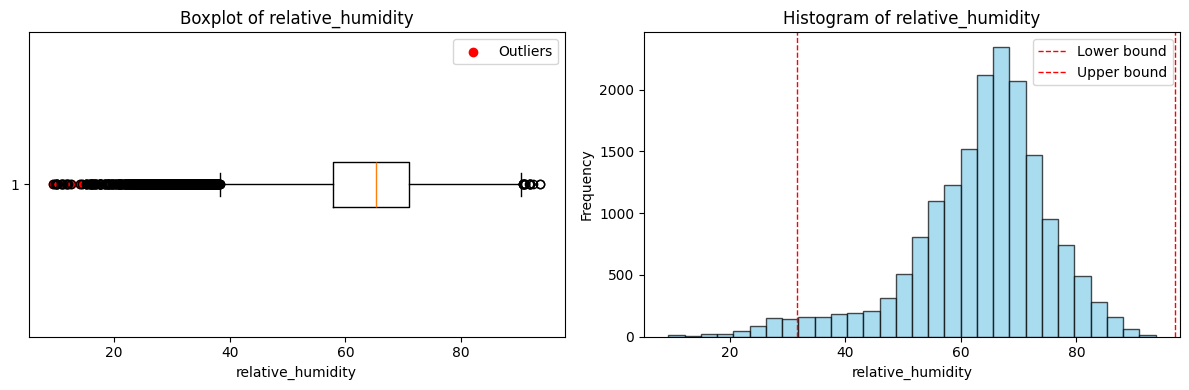

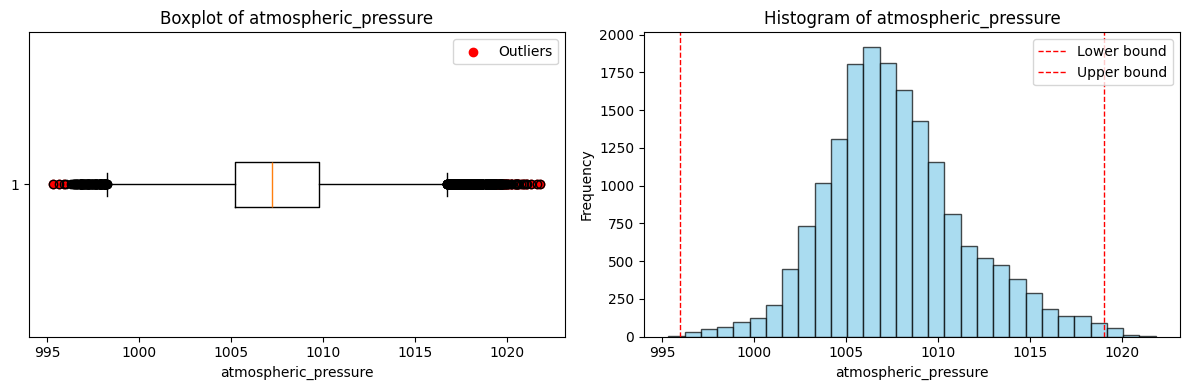

  air_temperature outlier row indices: [Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-06-29 15:00:00+0000', tz='UTC'), Timestamp('2023-06-29 16:00:00+0000', tz='UTC'), Timestamp('2023-06-29 17:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-14 15:00:00+0000', tz='UTC'), Timestamp('2023-07-14 16:00:00+0000', tz='UTC'), Timestamp('2023-07-14 17:00:00+0000', tz='UTC'), Timestamp('2023-07-14 18:00:00+0000', tz='UTC'), Timestamp('2023-07-31 14:00:00+0000', tz='UTC'), Timestamp('2023-08-21 17:00:00+0000', tz='UTC'), Timestamp('2023-08-22 11:00:00+0000', tz='UTC'), Timestamp('2023-08-22 12:00:00+0000', tz='UTC'), Timestamp('2023-08-22 13:00:00+0000', tz='UTC'), Timestamp('2023-08-22 14:00:00+0000', tz='UTC'), Timestamp('2023-08-22 15:00:00+0000', tz='UTC'), Timestamp('2023-08-22 16:00:0

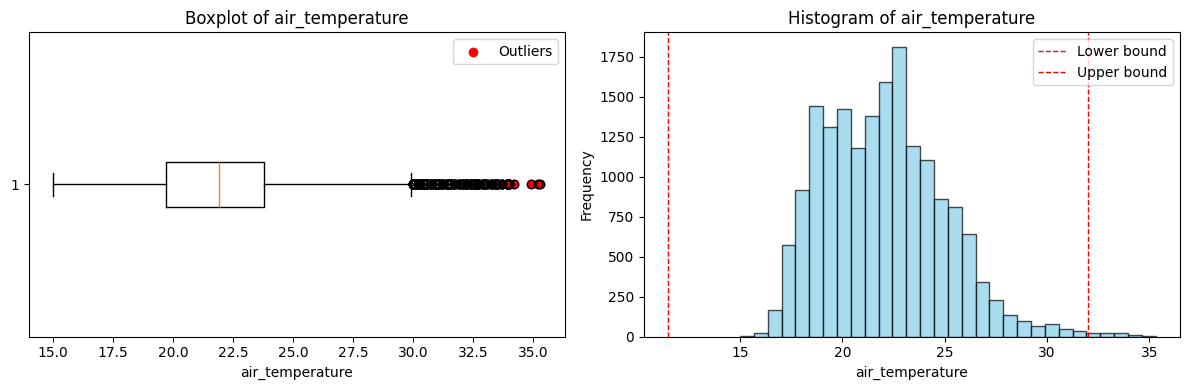

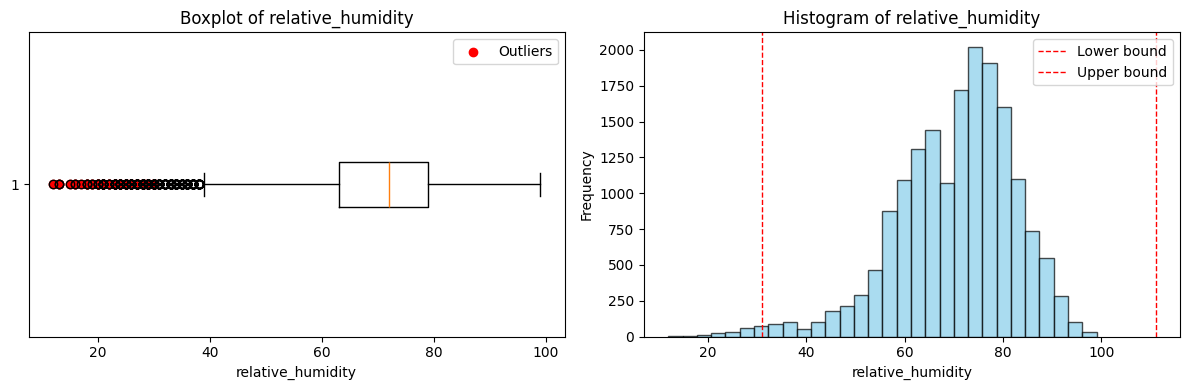

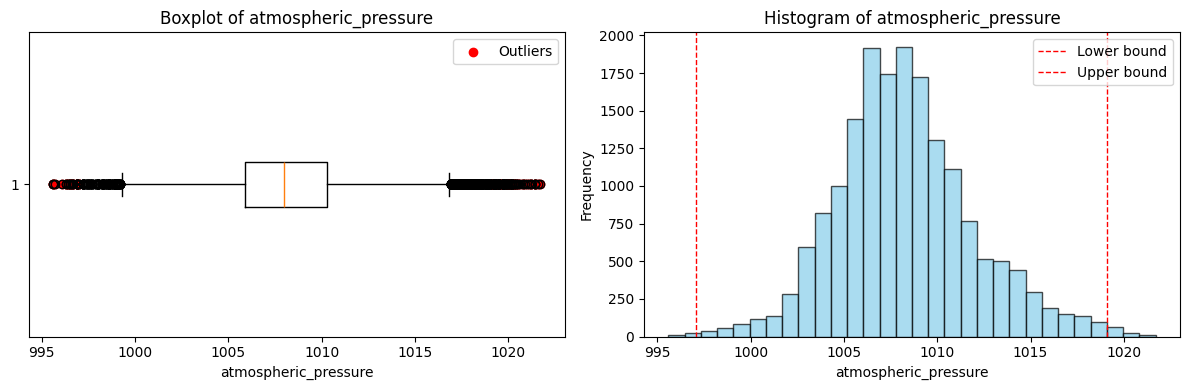

  air_temperature outlier row indices: [Timestamp('2023-06-29 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 12:00:00+0000', tz='UTC'), Timestamp('2023-07-13 13:00:00+0000', tz='UTC'), Timestamp('2023-07-13 14:00:00+0000', tz='UTC'), Timestamp('2023-07-13 15:00:00+0000', tz='UTC'), Timestamp('2023-07-13 16:00:00+0000', tz='UTC'), Timestamp('2023-07-13 17:00:00+0000', tz='UTC'), Timestamp('2023-08-11 12:00:00+0000', tz='UTC'), Timestamp('2023-08-11 13:00:00+0000', tz='UTC'), Timestamp('2023-08-11 14:00:00+0000', tz='UTC'), Timestamp('2023-08-11 15:00:00+0000', tz='UTC'), Timestamp('2023-08-11 16:00:00+0000', tz='UTC'), Timestamp('2023-08-11 17:00:00+0000', tz='UTC'), Timestamp('2023-08-12 11:00:00+0000', tz='UTC'), Timestamp('2023-08-12 12:00:00+0000', tz='UTC'), Timestamp('2023-08-12 13:00:00+0000', tz='UTC'), Timestamp('2023-08-12 14:00:00+0000', tz='UTC'), Timestamp('2023-08-12 15:00:00+0000', tz='UTC'), Timestamp('2023-08-12 16:00:00+0000', tz='UTC'), Timestamp('2023-08-12 17:00:0

In [36]:
threshold = 2
columns = ["air_temperature", "relative_humidity", "atmospheric_pressure"]

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, columns, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    # df_clean = df_hourly.drop(list(all_outlier_indices))
    # dataframes[file_key] = df_clean
    
    print(f"Detected {len(all_outlier_indices)} rows with outliers from {file_key}.\n")

### KNN

Processing grafcan_santa_cruz for KNN outlier detection...
air_temperature


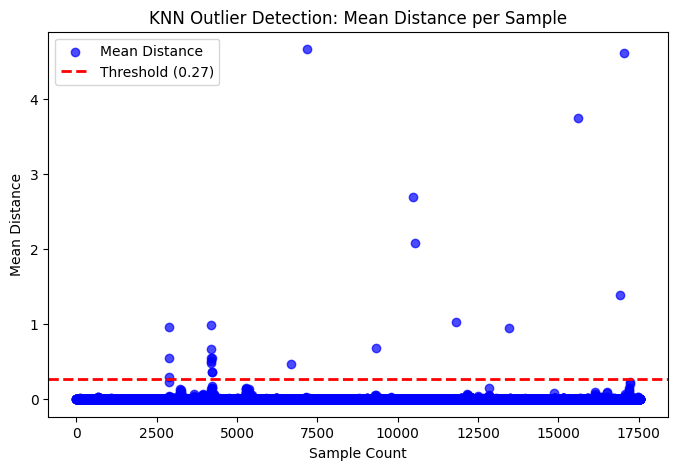

Detected 21 outliers at indices: [ 2894  2895  2896  4188  4189  4190  4191  4192  4211  4212  4215  6691
  7182  9325 10468 10544 11816 13469 15629 16926 17048]
atmospheric_pressure


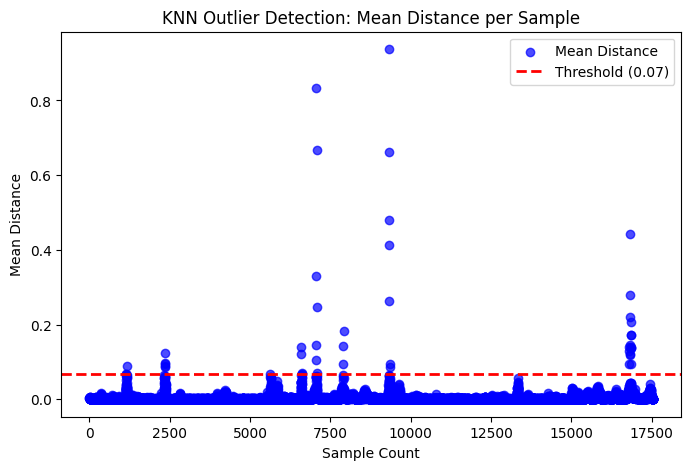

Detected 45 outliers at indices: [ 1147  1156  2342  2343  2344  2345  2346  5633  6594  6596  6606  6607
  7063  7064  7065  7066  7067  7068  7069  7905  7906  7907  9326  9327
  9328  9329  9330  9340  9341 16786 16787 16788 16833 16834 16835 16836
 16837 16838 16844 16845 16846 16847 16848 16849 16859]
relative_humidity


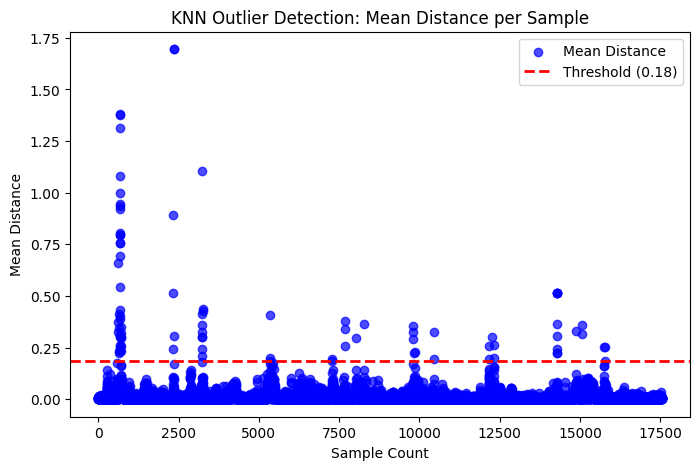

Detected 91 outliers at indices: [  612   613   614   656   657   659   660   669   670   671   672   673
   674   675   676   677   678   679   680   681   682   683   684   685
   686   687   688   689   690   691   692   693   694   695   696   699
   700   701  2339  2340  2341  2363  2364  2365  3239  3240  3241  3242
  3243  3244  3245  3246  3247  3248  5355  5360  5361  7281  7282  7689
  7690  7691  8029  8260  9802  9803  9804  9843  9869 10447 10448 12149
 12171 12270 12318 12319 14282 14283 14284 14285 14286 14287 14288 14289
 14290 14866 15072 15073 15746 15768 15769]
Processing openmeteo_santa_cruz for KNN outlier detection...
air_temperature


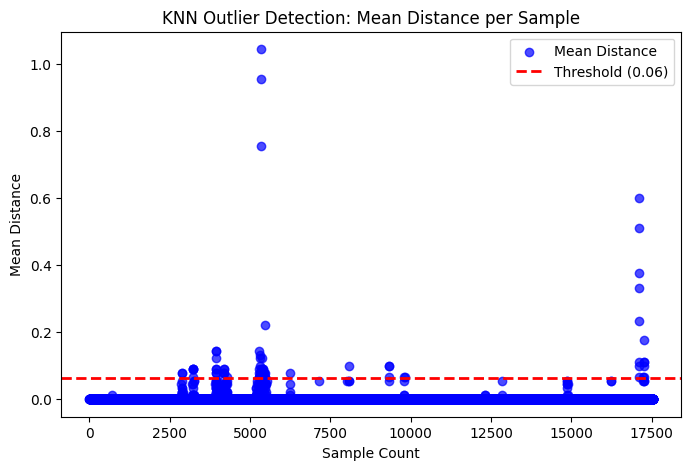

Detected 78 outliers at indices: [ 2869  2893  3227  3229  3230  3231  3232  3923  3924  3925  3928  3948
  3952  3953  4168  4188  4189  4190  4192  4283  5268  5269  5271  5272
  5292  5293  5294  5295  5296  5315  5317  5318  5320  5321  5338  5339
  5340  5341  5343  5344  5346  5362  5363  5364  5369  5387  5389  5391
  5392  5415  5437  5438  5439  5459  5462  5463  5464  6231  8072  9309
  9310  9311  9805  9806 17090 17091 17092 17093 17094 17095 17096 17097
 17215 17260 17261 17262 17263 17264]
atmospheric_pressure


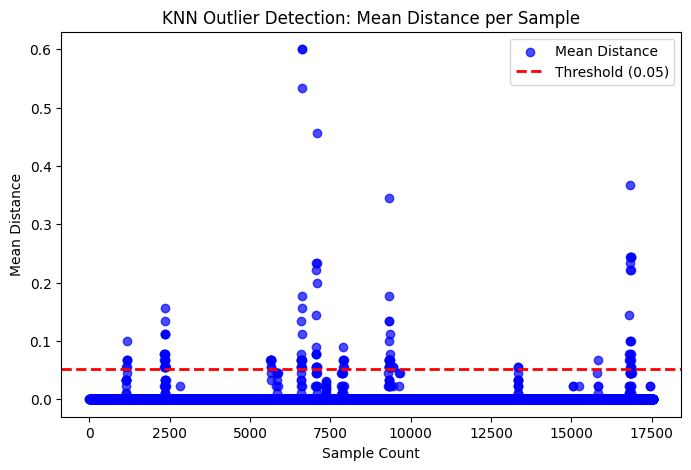

Detected 120 outliers at indices: [ 1150  1154  1155  1156  1157  1159  2331  2333  2334  2335  2337  2339
  2340  2342  2343  2344  2345  2346  2347  2348  2353  2356  2366  2368
  5633  5635  5638  5640  5641  5642  5643  5645  6584  6591  6593  6594
  6595  6596  6597  6598  6599  6601  6602  6603  6604  6605  6606  6607
  6608  6609  7044  7054  7055  7056  7057  7061  7063  7064  7065  7066
  7067  7068  7069  7071  7076  7883  7894  7904  7906  7907  7908  9316
  9317  9318  9319  9320  9321  9323  9327  9328  9329  9330  9331  9332
  9336  9339  9340  9342  9344  9346  9349  9351  9352  9453  9456 13336
 13339 15814 16787 16788 16797 16811 16821 16822 16825 16827 16834 16835
 16836 16837 16838 16844 16845 16846 16847 16848 16850 16851 16859 16860]
relative_humidity


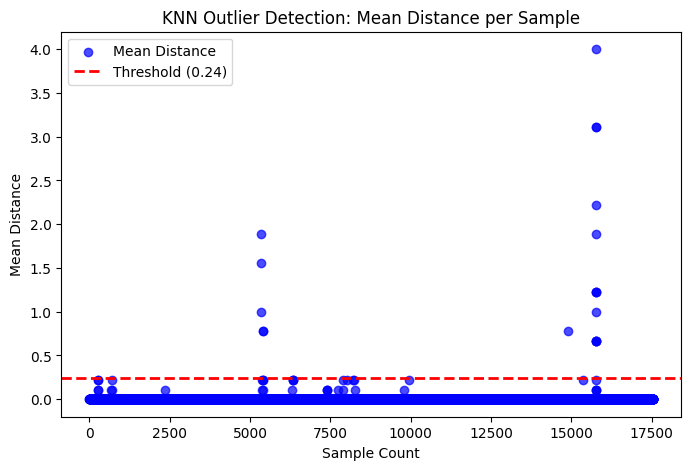

Detected 19 outliers at indices: [ 5338  5339  5340  5390  5391 14891 15751 15752 15753 15754 15755 15756
 15757 15758 15759 15761 15762 15766 15767]


In [37]:
def knn_outlier_detection(data, k=10, threshold=4):
    """
    Detect outliers using K-Nearest Neighbors.
    
    Parameters:
    - data: 1D numpy array of values.
    - k: Number of neighbors to consider.
    - threshold: Multiplier for the mean distance to determine outliers.
    
    Returns:
    - outliers: Indices of detected outliers.
    """
    data = data.reshape(-1, 1)  # Reshape for sklearn compatibility
    
    nbrs = NearestNeighbors(n_neighbors=k)
    nbrs.fit(data)
    distances, _ = nbrs.kneighbors(data)
    
    mean_distances = distances[:, 1:].mean(axis=1)  # Ignore self-distance (0)
    
    threshold_value = mean_distances.mean() + threshold * mean_distances.std()
    outliers = np.where(mean_distances > threshold_value)[0]
    
    # Plot distance distribution with better bin scaling
    plt.figure(figsize=(8, 5))
    plt.scatter(np.arange(len(mean_distances)), mean_distances, color='b', alpha=0.7, label='Mean Distance')
    plt.axhline(threshold_value, color='r', linestyle='dashed', linewidth=2,
                label=f'Threshold ({threshold_value:.2f})')
    #plt.yscale('log')  # Log scale for y-axis
    plt.xlabel('Sample Count')
    plt.ylabel('Mean Distance')
    plt.title('KNN Outlier Detection: Mean Distance per Sample')
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers at indices: {outliers}")
    
    return outliers

for name, df in dataframes.items(): 
    print(f"Processing {name} for KNN outlier detection...")
    
    # Flag outliers initialized at 0
    flag = np.zeros(len(df), dtype=int)

    print("air_temperature")
    data = df["air_temperature"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    print("atmospheric_pressure")
    data = df["atmospheric_pressure"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1
    
    print("relative_humidity")
    data = df["relative_humidity"].values
    outliers = knn_outlier_detection(data)
    flag[outliers] = 1

    # Assign this flag array as a new column
    df["outlier_flag"] = flag

Plotting histogram for grafcan_santa_cruz...


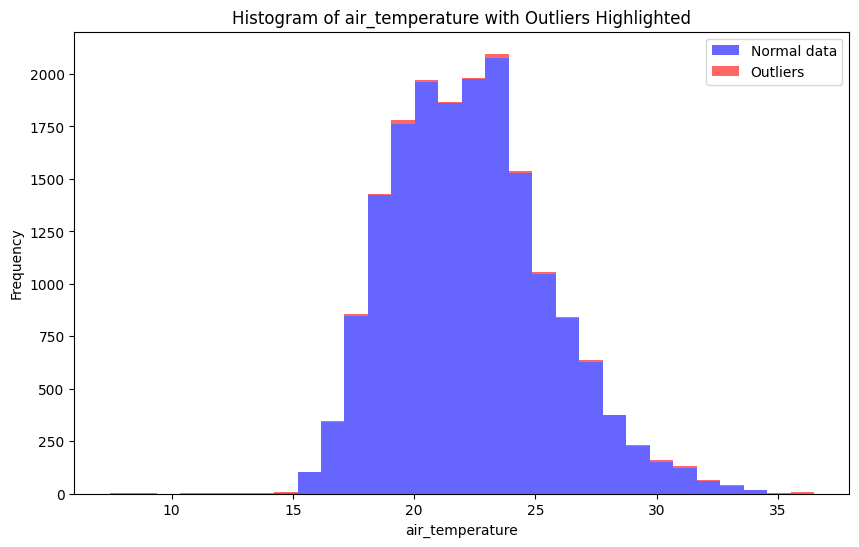

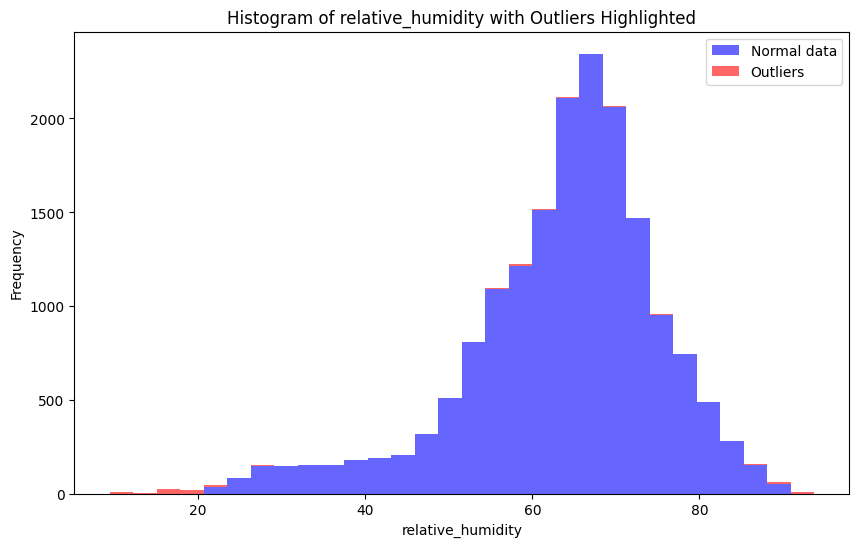

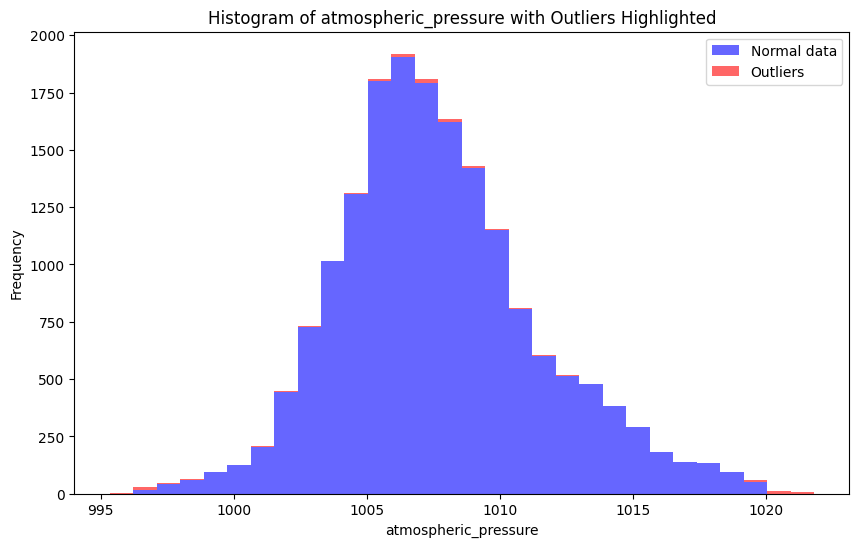

Plotting histogram for openmeteo_santa_cruz...


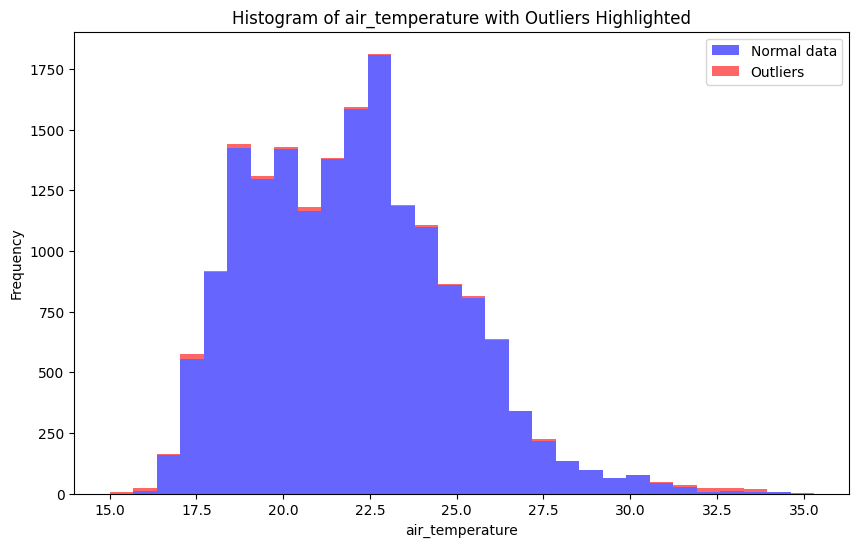

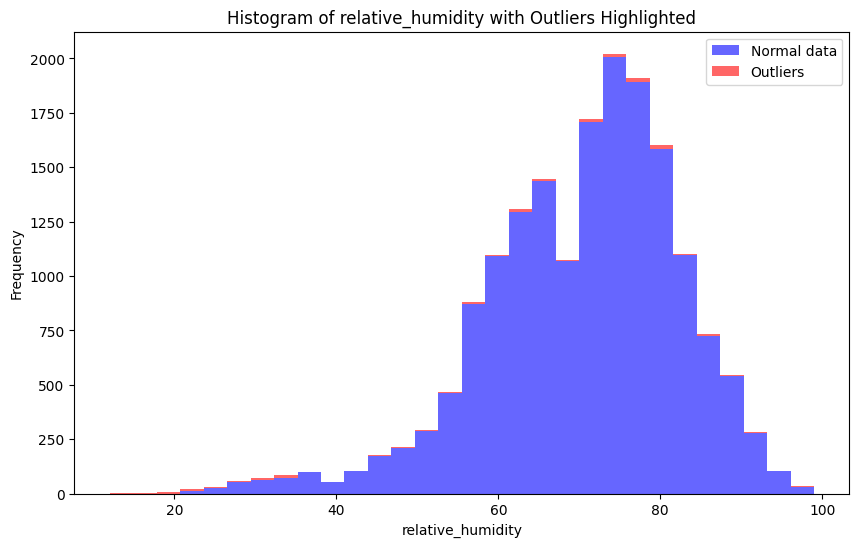

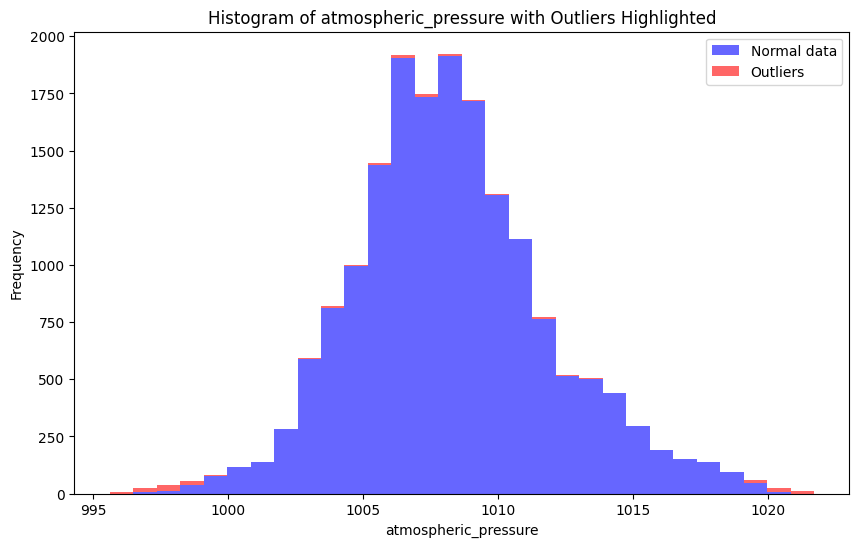

In [38]:
def plot_histogram_with_outliers(df, column, outlier_flag_column='outlier_flag', bins=30):
    """
    Plots a histogram for a specified column in the DataFrame, highlighting outliers.
    
    Parameters:
    - df: DataFrame containing the data.
    - column: Column name (string) for which to plot the histogram.
    - outlier_flag_column: Column name (string) containing the outlier flags (default 'outlier_flag').
    - bins: Number of bins for the histogram (default 30).
    """
    plt.figure(figsize=(10, 6))
    

    # Define bin edges based on the full dataset
    bin_edges = np.histogram_bin_edges(df[column], bins=bins)
    
    # Plot normal data histogram
    plt.hist([df.loc[df[outlier_flag_column] == 0, column], df.loc[df[outlier_flag_column] == 1, column]], stacked=True, bins=bin_edges, 
             color=['blue', 'red'], alpha=0.6, label=['Normal data', 'Outliers'])
    
    plt.xlabel(column)
    plt.ylabel("Frequency")
    #plt.yscale('log')  # Log scale for y-axis
    plt.title(f"Histogram of {column} with Outliers Highlighted")
    plt.legend()
    plt.show()

# Example usage:
for df_key in dataframes.keys():
    print(f"Plotting histogram for {df_key}...")
    plot_histogram_with_outliers(dataframes[df_key], "air_temperature")
    plot_histogram_with_outliers(dataframes[df_key], "relative_humidity")
    plot_histogram_with_outliers(dataframes[df_key], "atmospheric_pressure")

## Exploración frecuencias - Fourier

In [39]:
def plot_frequencies(df, column, freq_min, freq_max, top_n=3, sampling_interval=3600):
    values = df[column].values  # Extraer la columna de valores
    
    fft_result = np.fft.fft(values)  # Calcular la FFT
    frequencies = np.fft.fftfreq(len(values), d=sampling_interval)  # Calcular las frecuencias
    
    # Solo conservar las frecuencias positivas
    positive_frequencies = frequencies[:len(values) // 2]
    positive_fft_result = fft_result[:len(values) // 2]
    magnitude = np.abs(positive_fft_result)
    
    # Filtrar las frecuencias dentro del rango deseado
    mask = (positive_frequencies >= freq_min) & (positive_frequencies <= freq_max)
    filtered_frequencies = positive_frequencies[mask]
    filtered_magnitude = magnitude[mask]
    
    # Encontrar los índices de las N frecuencias con mayor magnitud
    top_indices = np.argsort(filtered_magnitude)[-top_n:]
    
    # Imprimir las N frecuencias principales
    print(f"Top {top_n} frequencies with highest magnitude:")
    for idx in top_indices:
        frequency_hz = filtered_frequencies[idx]
        period_hours = 1 / (frequency_hz * 3600)
        print(f"Frequency: {frequency_hz:.8f} Hz, Period: {period_hours:.2f} hours, Magnitude: {filtered_magnitude[idx]:.4f}")
    
    # Graficar el espectro de frecuencia con escala logarítmica en el eje X
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_frequencies, filtered_magnitude, label='Frequency Spectrum')
    
    # Resaltar las N frecuencias principales
    top_frequencies = filtered_frequencies[top_indices]
    top_magnitudes = filtered_magnitude[top_indices]
    plt.scatter(top_frequencies, top_magnitudes, color='red', zorder=5, label=f'Top {top_n} Frequencies')
    
    # Configurar escala logarítmica para el eje X
    plt.xscale('log')
    plt.xlabel('Frequency (Hz, log scale)')
    plt.ylabel('Magnitude')
    plt.title(f'{column}: Frequency Spectrum between {freq_min} Hz and {freq_max} Hz')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Plotting frequencies for grafcan_santa_cruz...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 4741.2421
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 4786.0953
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 6292.0674
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 17430.5889
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 28102.7725


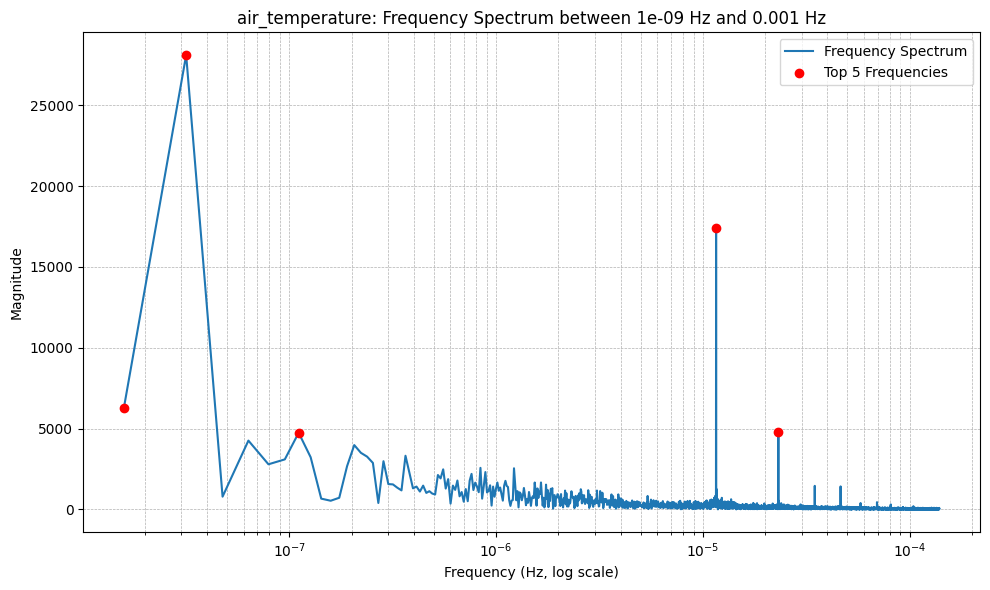

Top 5 frequencies with highest magnitude:
Frequency: 0.00000109 Hz, Period: 254.26 hours, Magnitude: 17640.5855
Frequency: 0.00000008 Hz, Period: 3508.80 hours, Magnitude: 17681.9575
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 18932.6191
Frequency: 0.00000030 Hz, Period: 923.37 hours, Magnitude: 19143.6857
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 37666.3704


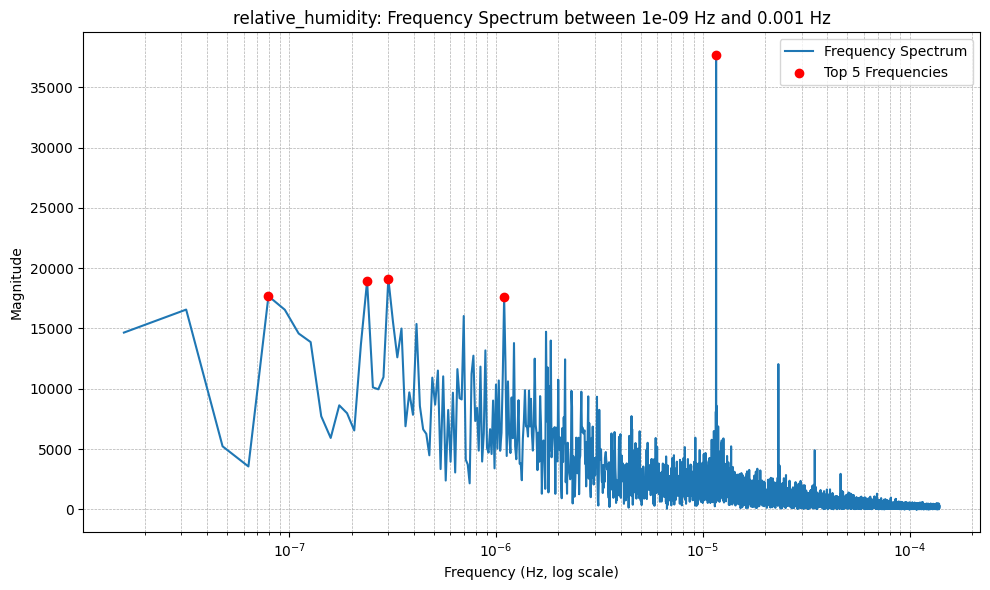

Top 5 frequencies with highest magnitude:
Frequency: 0.00000009 Hz, Period: 2924.00 hours, Magnitude: 7015.5406
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7579.5356
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 8106.2225
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12109.0220
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24185.6639


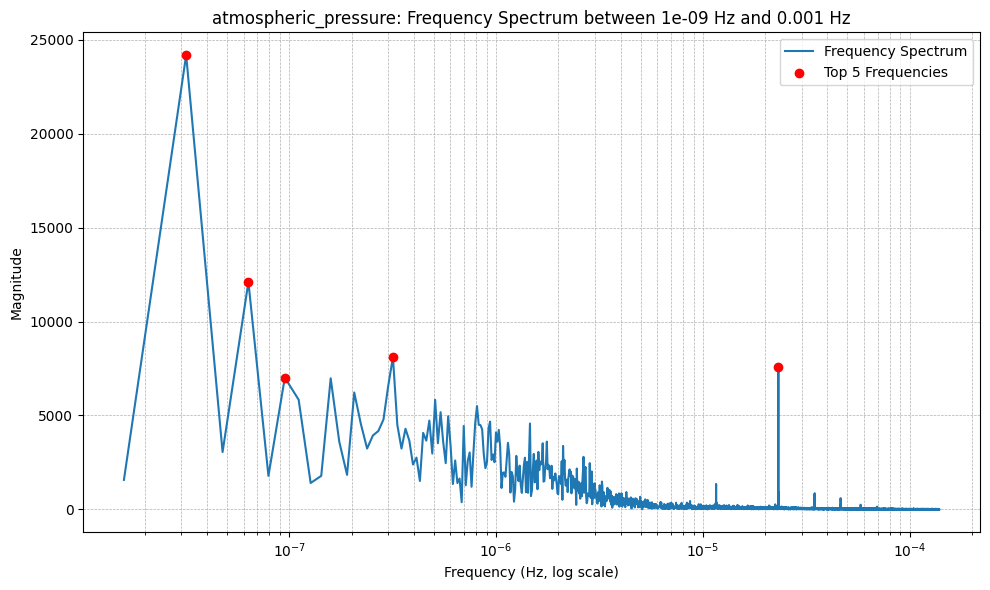

Plotting frequencies for openmeteo_santa_cruz...
Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 4222.2050
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 6090.0557
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 6465.4876
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 17126.9960
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 24538.4319


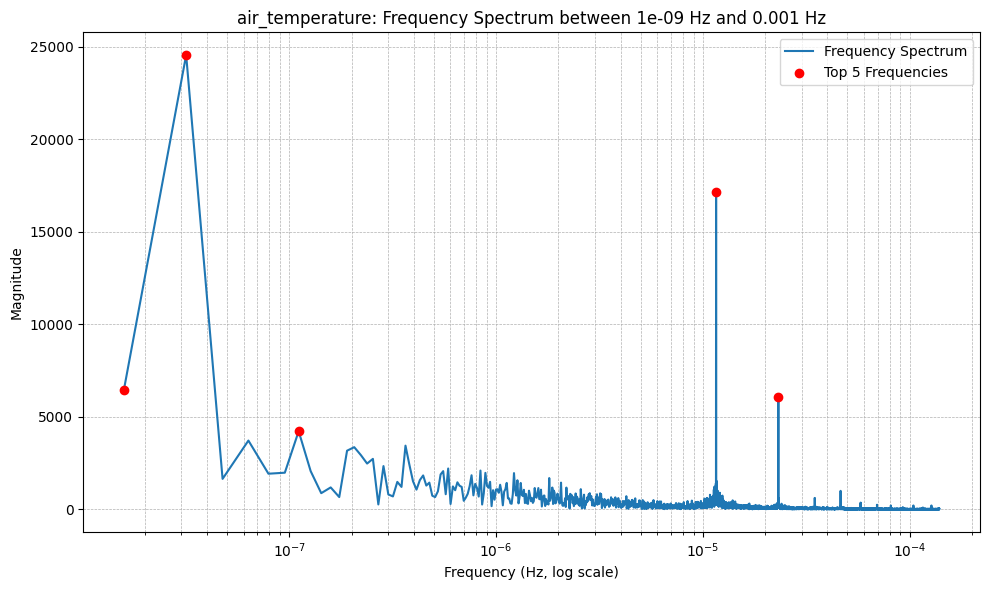

Top 5 frequencies with highest magnitude:
Frequency: 0.00000011 Hz, Period: 2506.29 hours, Magnitude: 16338.1063
Frequency: 0.00000024 Hz, Period: 1169.60 hours, Magnitude: 17074.8192
Frequency: 0.00000002 Hz, Period: 17544.00 hours, Magnitude: 17411.9118
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 27106.2827
Frequency: 0.00001157 Hz, Period: 24.00 hours, Magnitude: 89211.1156


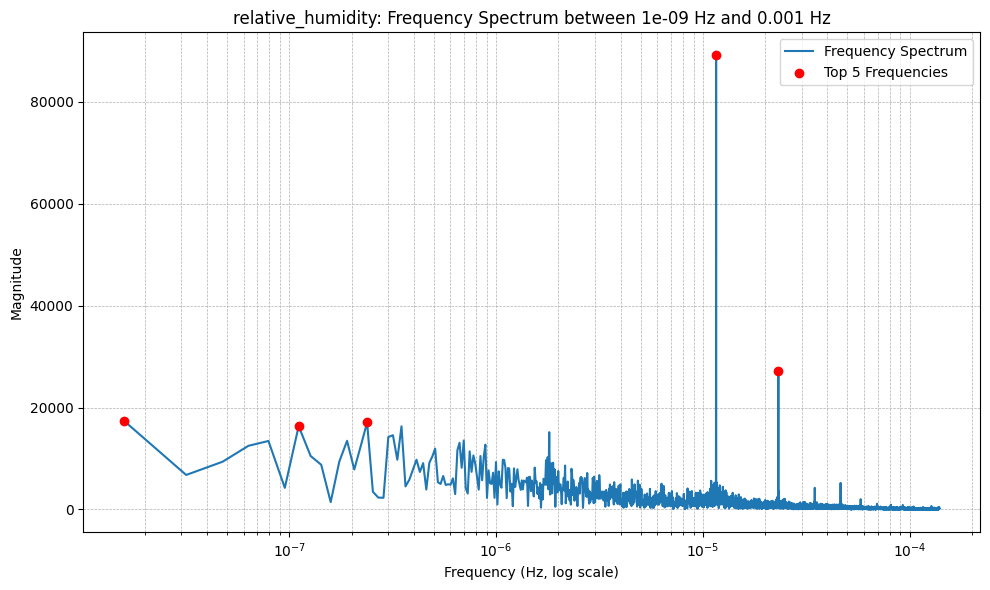

Top 5 frequencies with highest magnitude:
Frequency: 0.00000016 Hz, Period: 1754.40 hours, Magnitude: 7301.8815
Frequency: 0.00002315 Hz, Period: 12.00 hours, Magnitude: 7399.8797
Frequency: 0.00000032 Hz, Period: 877.20 hours, Magnitude: 8032.0318
Frequency: 0.00000006 Hz, Period: 4386.00 hours, Magnitude: 12237.9316
Frequency: 0.00000003 Hz, Period: 8772.00 hours, Magnitude: 20308.7369


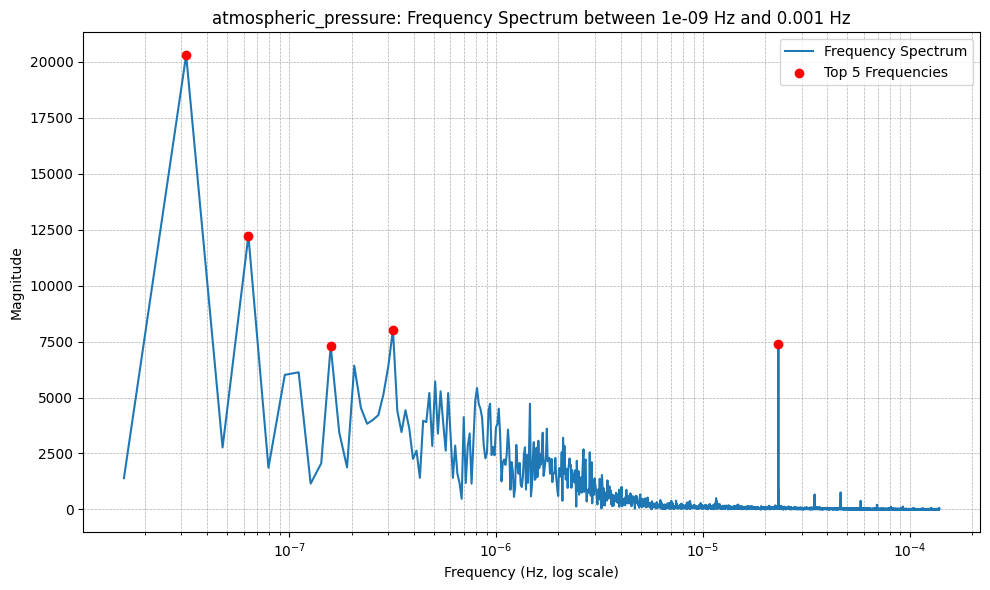

In [40]:
min_frequency = 10**-9
max_frequency = 10**-3
top_n = 5

for name, df in dataframes.items():
  print(f"Plotting frequencies for {name}...")
  plot_frequencies(df, "air_temperature", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "relative_humidity", min_frequency, max_frequency, top_n)
  plot_frequencies(df, "atmospheric_pressure", min_frequency, max_frequency, top_n)

## Adición datos temporales

In [41]:
def add_time_features(df): 
    # Extract hour and minute to get a more continuous representation of time within a day
    df.index.name = "time"
    df.reset_index(inplace=True)

    df['time'] = pd.to_datetime(df['time'])
    hours = df['time'].dt.hour
    minutes  = df['time'].dt.minute
    hour_fraction = hours + minutes / 60.0

    # Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
    df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
    df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

    # Extract day of the week (0 = Monday, 6 = Sunday)
    day_of_week = df['time'].dt.weekday
    week_fraction = day_of_week + hour_fraction / 24.0  

    df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
    df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

    # For annual features: extract the day of the year (1-366)
    day_of_year = df['time'].dt.dayofyear

    # Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
    year_fraction = (day_of_year - 1) + hour_fraction / 24.0

    def is_leap_year(year):
        return (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0)
    
    # Apply the leap year function and store the result
    df['leap_year'] = df['time'].dt.year.apply(is_leap_year)

    df['sin_year'] = np.sin(2 * np.pi * year_fraction / (365 + df['leap_year']))
    df['cos_year'] = np.cos(2 * np.pi * year_fraction / (365 + df['leap_year']))

    # Drop the aux leap year variable
    df.drop(columns="leap_year", inplace=True)
                            
    # Remove original time variable
    #df.drop(columns="time", inplace=True)
    
for df in dataframes.values():
    add_time_features(df)


Plotting correlations for grafcan_santa_cruz...


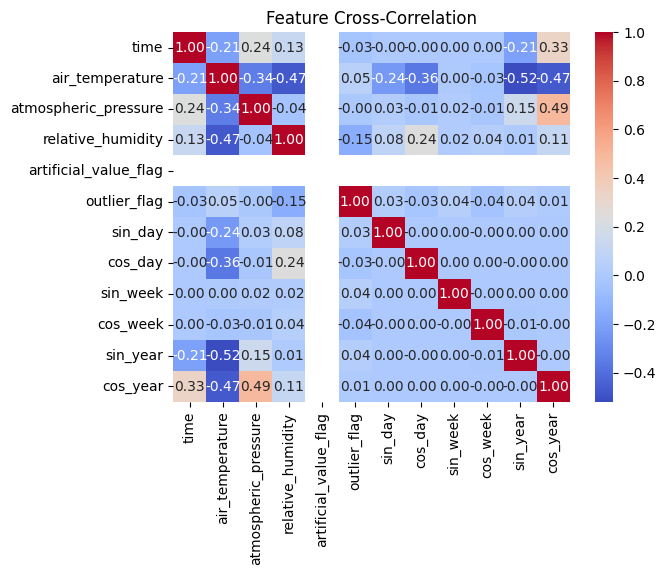

Plotting correlations for openmeteo_santa_cruz...


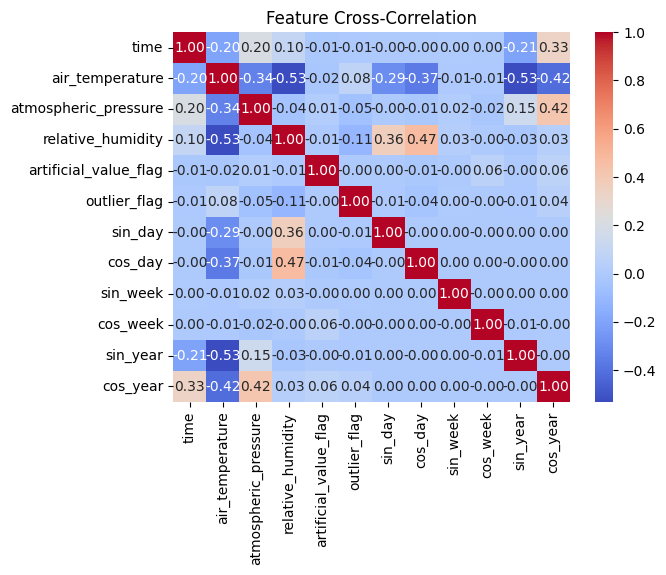

In [42]:
for name, df in dataframes.items():
  print (f"Plotting correlations for {name}...")
  
  correlation_matrix = df.corr()

  # Heatmap for visualization
  sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Feature Cross-Correlation")
  plt.show()


In [43]:
for df in dataframes.values():
  df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Escritura fichero 

In [44]:
for name, df in dataframes.items():
  df.to_csv("processed_data/" + name + "_features.csv", index=False)